# Prediction de Loyer

Commencons pas les imports nécessaires

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline  

### Exploration du Dataset

On va commencer par explorer rapidement le dataset car il est assez simple

In [2]:
house_data = pd.read_csv("house_data.csv")

In [3]:
print(house_data.head(), "\n")
print(house_data.info(), "\n")
print(house_data.describe(), "\n")
print(house_data["arrondissement"].value_counts())

   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0
2   1900     55.0             1.0
3   1950     46.0             1.0
4   1950     49.0             1.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 3 columns):
price             827 non-null int64
surface           822 non-null float64
arrondissement    822 non-null float64
dtypes: float64(2), int64(1)
memory usage: 19.5 KB
None 

              price     surface  arrondissement
count    827.000000  822.000000      822.000000
mean    2007.342201   58.045925        4.142336
std     1890.894229   44.827522        3.202151
min      390.000000   10.000000        1.000000
25%     1050.000000   28.655000        2.000000
50%     1567.000000   46.100000        3.000000
75%     2346.000000   73.000000        4.000000
max    25000.000000  415.000000       10.000000 

4.0     179
3.0     175
10.0    174
1.0     164
2.0     130
Name: arrondissement, d

On remarque dans un premier temps que l'on a 827 prix pour seulement 822 pour "surface" et "arrondissement". Il y a donc des données avec une information manquante. On peut soit les supprimer, soit utiliser le KNN pour remplir les vides. Avec 822 points de données, on a suffisament de points pour avoir une première estimation, si cela ne fit pas, on pourra tester le KNN.

On peut aussi voir que l'on a suffisament de points pour chaque arrondissement car on en a environ 170 par arrondissement sauf l'arrondissement 2 avec seulement 130 pts mais cela suffit pour ce type de modèle.

Pour avoir une autre vision du problème, on peut aussi afficher le prix en fonction de la surface avec des couleurs différentes pour chaque arrondissement. Ce qui donne :

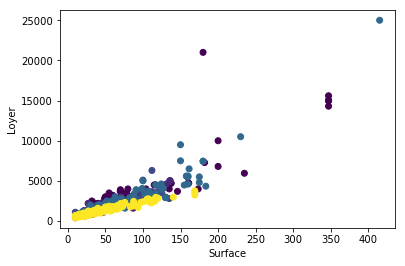

In [4]:
plt.scatter(house_data["surface"], house_data["price"], c=house_data["arrondissement"])
plt.xlabel('Surface')
plt.ylabel('Loyer')
plt.show()

### Traitement des données

##### Suppression des lignes avec une valeur manquante

In [5]:
house_data = house_data.dropna()
print(house_data.head(), "\n")
print(house_data.info(), "\n")
print(house_data.describe())

   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0
2   1900     55.0             1.0
3   1950     46.0             1.0
4   1950     49.0             1.0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 826
Data columns (total 3 columns):
price             822 non-null int64
surface           822 non-null float64
arrondissement    822 non-null float64
dtypes: float64(2), int64(1)
memory usage: 25.7 KB
None 

              price     surface  arrondissement
count    822.000000  822.000000      822.000000
mean    2010.306569   58.045925        4.142336
std     1895.091794   44.827522        3.202151
min      390.000000   10.000000        1.000000
25%     1052.500000   28.655000        2.000000
50%     1564.500000   46.100000        3.000000
75%     2348.000000   73.000000        4.000000
max    25000.000000  415.000000       10.000000


Le point rassurant c'est que sans les points sans valeurs, on n'a pas de gros changement sur les datas. La moyenne passe de 2007 à 2010€, StdDev passe de 1890 à 1885, le min et max reste identique. On peut donc estimer que l'on a pas supprimé de points particulièrements caractéristiques

###### Suppression des outliers
On a pu voir sur le graph que 2 points sont complètement abérants. Ce sont les 2 avec un loyer de plus de 20 000€. Les 3 points aux alentours de 15 000€ peuvent avoir une signification car ils sont sensiblement alignés mais les 2 autres sont des outliers. On peut donc les supprimer

In [6]:
house_data = house_data[house_data["price"] < 20000]

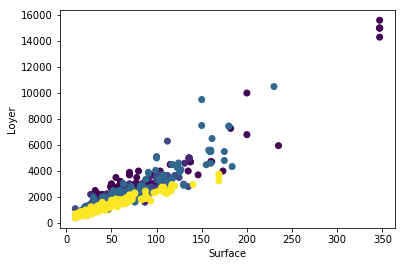

In [7]:
plt.scatter(house_data["surface"], house_data["price"], c=house_data["arrondissement"])
plt.xlabel('Surface')
plt.ylabel('Loyer')
plt.show()

Sans les 2 points, on peut remarquer que le nuage se recompacte un peu. Il semblerait logique de mettre aussi de coté les 3 points correspondent à une surface de 350m² ou l'on a aucun autre point venant d'un autre arrondissement, ils semblent representer un type d'appartement particulier.

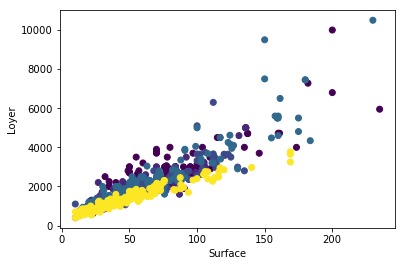

In [8]:
house_data = house_data[house_data["surface"] < 300]
plt.scatter(house_data["surface"], house_data["price"], c=house_data["arrondissement"])
plt.xlabel('Surface')
plt.ylabel('Loyer')
plt.show()

Voila !, Bien que l'on ai une grosse dispersion pour des grandes surfaces, le modèle semble un peu plus "propre". On peut donc decouper le dataset en 2

In [9]:
# séparation en training / testing set
training_set, test_set = train_test_split(house_data, test_size=0.2, random_state=42) 
# on fixe random pour avoir toujours le meme split et ainsi pouvoir comparer plus tard avec d'autres modèles

print("Training Set :")
print(training_set.describe(), "\n")
print(training_set["arrondissement"].value_counts(), "\n")
print("Test Set :")
print(test_set.describe())
print(test_set["arrondissement"].value_counts())

Training Set :
              price    surface  arrondissement
count    652.000000  652.00000      652.000000
mean    1888.854294   55.69569        4.199387
std     1234.859986   36.44252        3.236239
min      402.000000   10.00000        1.000000
25%     1057.500000   28.00000        2.000000
50%     1550.000000   46.00000        3.000000
75%     2329.250000   72.05000        4.000000
max    10500.000000  230.00000       10.000000 

10.0    143
4.0     139
3.0     138
1.0     126
2.0     106
Name: arrondissement, dtype: int64 

Test Set :
             price     surface  arrondissement
count   163.000000  163.000000      163.000000
mean   1840.730061   55.645153        4.030675
std    1139.820552   36.929831        3.080050
min     390.000000   10.000000        1.000000
25%    1049.000000   30.000000        2.000000
50%    1650.000000   46.470000        3.000000
75%    2282.000000   70.500000        4.000000
max    7500.000000  235.000000       10.000000
4.0     39
3.0     37
1.0    

On remarque que les 2 datasets sont assez similaires:
<li>Prix moyen proche (1888 vs 1840)</li>
<li>Variation du prix similaire (1234 vs 1140)</li>
<li>Surface moyenne très proche (55.6 m²)</li>
<li>Variation de surface très proche (36.44 vs 36.93)</li>
<li>La répartition des arrondissements est similaire</li>

On a donc nos 2 dataset pour le training et le test. O

# Mise en place des Modèles

#### Modèle 1

Le 1er modèle est le plus "simple". Il se base sur les 2 features que l'on a (surface et arrondissement) pour trouver une relation du type :

$$\begin{eqnarray}
  Prix = \alpha_1 * arrondissement +  \alpha_2 * surface + beta
\end{eqnarray}$$

On peut donc transformer les 2 sets en matrices pour la suite

In [10]:
X_train = training_set.drop(["price"], axis = 1)
y_train = training_set["price"]
X_test = test_set.drop(["price"], axis = 1)
y_test = test_set["price"]

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()
X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

print(X_train)

[[  18.    10. ]
 [ 114.     3. ]
 [  30.     3. ]
 ..., 
 [  34.     2. ]
 [  10.1    3. ]
 [  73.6    1. ]]


Voila on peut donc mettre en place notre modèle Linéaire avec comme evaluation le coefficient de determination qui est le plus commun pour tout ce qui est regression lineaire. Cela se fait avec la méthode <b>score</b> de la Regression linéaire.

In [11]:
regr = linear_model.LinearRegression()
a = regr.fit(X_train, y_train)
score = regr.score(X_test, y_test)

print("Score : ",score)
print("{:.2f} * Surface + {:.2f} * Arrondissement + {:.2f} = Prix".format(a.coef_[0], a.coef_[1], a.intercept_))

Score :  0.822652957731
30.23 * Surface + -54.31 * Arrondissement + 433.25 = Prix


82 %, c'est pas mal mais ce n'est pas bon. Pourquoi ? Ce qui se passe c'est que le prix n'evolue pas linéairement avec l'arrondissement. A surface fixe, le prix de l'arrondissement n'augmentera pas linéairement selon l'arrondissement. Cahque arrondissement a sa propre evolution. On peut voir ca en affichant notre regression pour chaque arrondissement.  

[[0, 1], [235.0, 1]]


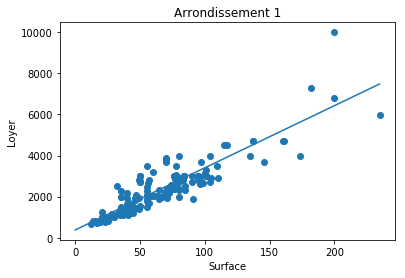

[[0, 2], [136.0, 2]]


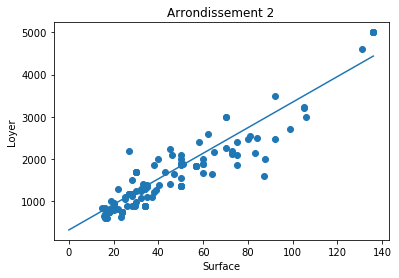

[[0, 3], [159.30000000000001, 3]]


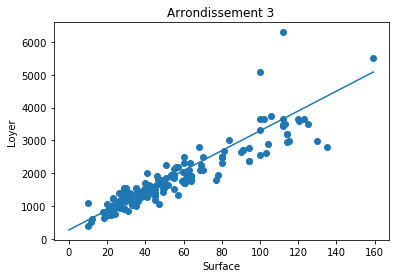

[[0, 4], [230.0, 4]]


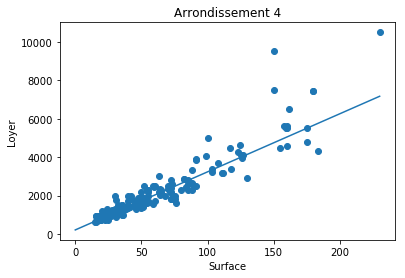

[[0, 10], [169.0, 10]]


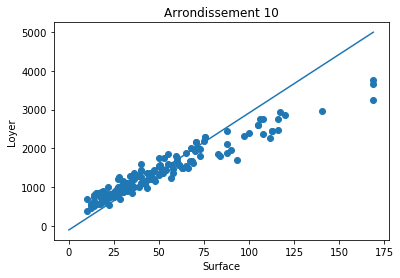

In [12]:
arrondissement_list = [1, 2, 3, 4, 10]
for index, arrondissement in enumerate(arrondissement_list):
    # recuperation des points pour chaque arrondissement
    house_data_spe = house_data[house_data["arrondissement"] == arrondissement]
    plt.scatter(house_data_spe["surface"], house_data_spe["price"])
    
    # creation de 2 point pour la ligne de regression linéaire
    x_pos_1, x_pos_2 = [0, max(house_data_spe['surface'])]
    X = [[x_pos_1, arrondissement],
         [x_pos_2, arrondissement]]
    
    Y = regr.predict(X)
    print(X)
    plt.plot([x_pos_1, x_pos_2], Y)
    
    # Affichage
    plt.title('Arrondissement {}'.format(arrondissement))
    plt.xlabel('Surface')
    plt.ylabel('Loyer')
    plt.show()

On remarque que globalement la regression fit bien les nuages de points sauf pour l'arrondissement 10. Celui-ci a une evolution plus lente en fonction de la surface. On peut aussi voir ce phénomène en affichant les prix en fonction de l'arrondissement à surface fixe (disons 50m² car on a des points pour chaque arrondissement à cette surface)

     price  surface  arrondissement
33    3000     50.0             1.0
58    2700     50.0             1.0
59    2700     50.0             1.0
129   1560     50.0             1.0
145   2750     50.0             1.0
146   3000     50.0             1.0
186   1900     50.0             2.0
188   1545     50.0             2.0
212   1850     50.0             2.0
216   2010     50.0             2.0
218   2100     50.0             2.0
245   1375     50.0             2.0
255   1375     50.0             2.0
265   1375     50.0             2.0
275   1375     50.0             2.0
285   1375     50.0             2.0
371   1750     50.0             3.0
384   1550     50.0             3.0
471   1800     50.0             4.0
477   1950     50.0             4.0
484   2200     50.0             4.0
556   1409     50.0             4.0
566   1380     50.0             4.0
650   1800     50.0             4.0
695   1750     50.0            10.0
706   1550     50.0            10.0
758   1550     50.0         

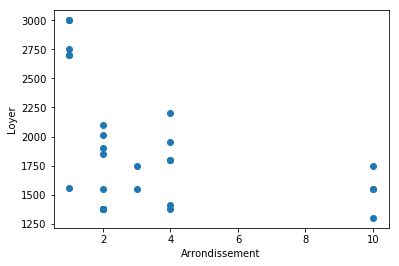

In [13]:
surf_fixe = house_data[house_data["surface"] == 50 ]
print(surf_fixe)
plt.scatter(surf_fixe["arrondissement"], surf_fixe["price"])
plt.xlabel('Arrondissement')
plt.ylabel('Loyer')
plt.show()

On peut voir sur cette representation que l'arrondissement 10 est globalement moins cher que le 1, le 3 est peu cher tandis que le 2 et le 4 sont similaires. Il faut donc un autre modèle.

#### Modèle 2

Le 2nd modèle est plus complexe. Il va prendre en compte chaque arrondissement dans une relation du type :

$$\begin{eqnarray}
  Prix = \alpha_0 * A_0 * surface + \alpha_1 * A_1 * surface + \alpha_2 * A_2 * surface + ... + beta
\end{eqnarray}$$

avec A_i valant 1 si l'appartement est dans l'arrondissement i sinon 0. Cela permet de gérérer une regression lineaire par arrondissement et ainsi d'avoir un modèle plus précis.

Cela se fait avec ce que l'on appelle un <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html" target="_blank">OneHotEncoder</a> founit dans scikit-learn

In [14]:
OHE = OneHotEncoder()
training_set_1hot = OHE.fit_transform(training_set["arrondissement"].values.reshape(-1,1))
test_set_1hot = OHE.transform(test_set["arrondissement"].values.reshape(-1,1))
print(training_set_1hot.toarray())

[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 ..., 
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


Voila on a donc converti nos arrondissement de datasets en une matrice. On peut donc la muliplier par ses prix

In [15]:
surface_training = training_set["surface"].values.reshape(-1, 1)
surface_test = test_set["surface"].values.reshape(-1, 1)

nb_feature = training_set_1hot.shape[1]

surface_training = np.tile(surface_training, nb_feature)
surface_test = np.tile(surface_test, nb_feature)

X_train = training_set_1hot.toarray() * surface_training
X_test = test_set_1hot.toarray() * surface_test

print(X_train, "\n")
print(X_test)

[[   0.     0.     0.     0.    18. ]
 [   0.     0.   114.     0.     0. ]
 [   0.     0.    30.     0.     0. ]
 ..., 
 [   0.    34.     0.     0.     0. ]
 [   0.     0.    10.1    0.     0. ]
 [  73.6    0.     0.     0.     0. ]] 

[[   0.     32.      0.      0.      0.  ]
 [   0.      0.     64.      0.      0.  ]
 [   0.      0.    120.48    0.      0.  ]
 [   0.     65.      0.      0.      0.  ]
 [   0.      0.      0.      0.     10.  ]
 [   0.      0.      0.      0.     14.  ]
 [   0.     37.      0.      0.      0.  ]
 [   0.      0.     60.84    0.      0.  ]
 [   0.      0.     54.      0.      0.  ]
 [   0.      0.      0.     19.      0.  ]
 [  79.82    0.      0.      0.      0.  ]
 [   0.      0.      0.      0.     27.  ]
 [   0.      0.     27.08    0.      0.  ]
 [   0.      0.      0.      0.     10.  ]
 [   0.     34.      0.      0.      0.  ]
 [   0.      0.     29.      0.      0.  ]
 [   0.      0.    112.      0.      0.  ]
 [ 101.      0.      0.      0.

In [16]:
regr2 = linear_model.LinearRegression()
a = regr2.fit(X_train, y_train)
score = regr2.score(X_test, y_test)

print("Score : ", score)
print(a.coef_, a.intercept_)

Score :  0.830749508976
[ 32.13428898  29.81342804  28.39580741  33.02682548  21.63924297] 260.322407929


Le score n'est pas beaucoup plus haut mais on a tout de meme pu modeliser par arrondissement "l'équation" du prix. On remarque que comme "deviné" precedemment, s'il y avait une relation lineaire entre les arrondissements, on aurait une linéarité des coeffs ce dessus et ce n'est pas le cas. On remarque que l'arrondissement 10 est le moins sensible au prix du m² (21 €/m²), l'arrondissement 1 et 4 sont les plus cher au m² (>32€/m²), l'arrondissement 2 et 3 sont similaires (29.8 €/m² vs 28.4 €/m²)


Ce modèle a juste 2 bémols :
<li>On n'a qu'un seul Bias pour tous les arrondissements ce qui n'est pas très réaliste</li>
<li>Avec le OHE, on a un risque d'avoir le problème du <b>fléau de la dimension</b>. Dans ce cas, ca va car on a tout de même plus de 100 points par dimensions ce qui est suffisant pour une regression linéaire. Si on avait 65 arrondissements, on aurait manqué de données avec seulement une dizaine de pts par arrondissement en moyenne.</li>

On peut aussi afficher la courbe par arrondissement voir si les resultats ne sont pas abérants

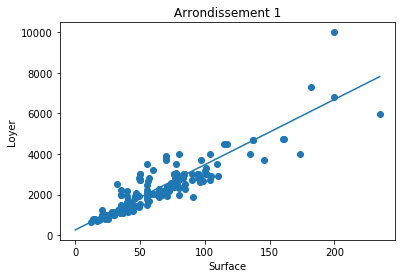

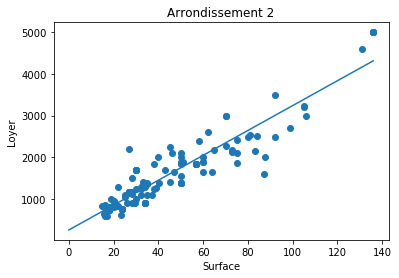

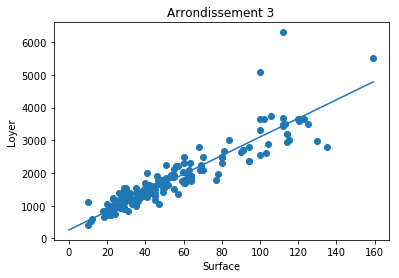

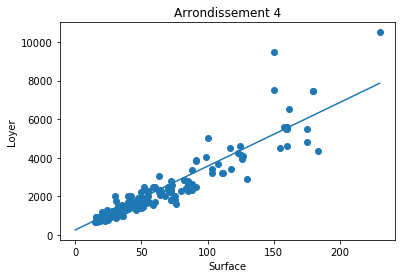

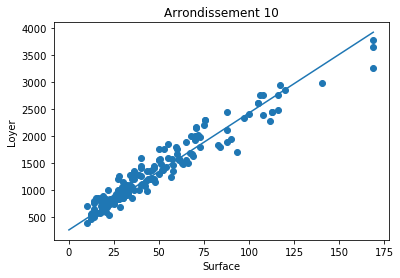

In [17]:
arrondissement_list = [1, 2, 3, 4, 10]
for index, arrondissement in enumerate(arrondissement_list):
    # recuperation des points pour chaque arrondissement
    house_data_spe = house_data[house_data["arrondissement"] == arrondissement]
    plt.scatter(house_data_spe["surface"], house_data_spe["price"])
    
    # creation de 2 points pour la ligne de regression linéaire. Simule un OHE, pour chaque arrondissement
    x_pos_1, x_pos_2 = [0, max(house_data_spe['surface'])]
    X = [[0 for i in range(5)],
         [x_pos_2 if i == index else 0 for i in range(5)]]
    
    # NB: un pipeline peut etre créer pour modifier directement les datas avant de les passer dans le modèle.
    # cela evite de devoir coder soit meme les 2 points pour la regression
    
    Y = regr2.predict(X)
    plt.plot([x_pos_1, x_pos_2], Y)
    
    # Affichage
    plt.title('Arrondissement {}'.format(arrondissement))
    plt.xlabel('Surface')
    plt.ylabel('Loyer')
    plt.show()

# Conclusion

On a donc un modèle qui fit correctement les petites surfaces mais plus difficilement les grandes surfaces (surtout dans certains arrondissements). Il faudrait des informations supplémentaire car on peut imaginer qu'une maison de 250 m² a peut être une piscine, un garage, un jardin qui donne un surprlus au prix de la maison. Cependant pour la majorité des "petites" surface (<150 m²) les résultats sont plutôt bons car la régression fit bien les points de données. Une dernière amélioration possible serait de faire une regression par arrondissement pour avoir un biais par arrondissement (par exemple sur les graphs ci dessus, on peut voir qu'un biais légèrement plus petit fitterait mieux le dataset dans l'arrondissement 4) mais cela rend moins facile sur utilisation plus tard. Le modèle final serait donc le 2nd modèle avec le OneHotEncoder.